In [1]:
import os
from itertools import product
import config
import json
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
get_model_name = lambda dataset, model_type, curriculum: os.path.join(dataset + ("_" + model_type) + "_" + curriculum.split(".")[0])
import util
import re


In [2]:
get_model_name = lambda dataset, model_type, curriculum: os.path.join(dataset + ("_" + model_type) + "_" + curriculum.split(".")[0])

jobs =[(get_model_name(dataset, model_type, curriculum), dataset, model_type, curriculum) for dataset, model_type, curriculum in product(config.datasets, config.model_types, config.baseline_curricula)]
jobs.extend([(get_model_name(dataset, model_type, model_type + curriculum), dataset, model_type, model_type + curriculum) for dataset, model_type, curriculum  in (product(config.datasets, config.model_types, config.influence_curricula))])
jobs.extend([(model_name, "external", model_type, model_type) for model_name, model_type in config.baseline_models])
print("len jobs", len(jobs))

len jobs 88


In [3]:
# reading time benchmark
def get_df(model, dataset, model_type, curriculum):
  


    report_path = f"./results/{os.path.basename(model)}/main/zero_shot/{'causal/reading' if 'bert' not in model else 'mlm/reading/3_mask_tokens'}/report.txt"

    df = None
    with open(report_path, "r") as f:
        d = f.read()
     
        data = []

        for line in d.splitlines():
            line = line.strip()
            key, value = line.split(":", 1)
            data.append({"task": key.strip(), "$Avg \% $R^2$ Gain": float(value.strip())/100})

        df = pd.DataFrame(data)
        df[["model", "dataset", "model_type", "curriculum"]] = model, dataset, model_type, curriculum

        return df

from itertools import chain

df = pd.concat(get_df(*job) for job in jobs)

In [4]:
df

,task,$Avg \% $R^2$ Gain,model,dataset,model_type,curriculum
0,EYE TRACKING SCORE,0.0049,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt
1,SELF-PACED READING SCORE,0.0006,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt
0,EYE TRACKING SCORE,0.0058,loris3/babylm_2024_10m_curriculum_llama_source_difficulty,loris3/babylm_2024_10m_curriculum,llama,source_difficulty.pt
1,SELF-PACED READING SCORE,0.0007,loris3/babylm_2024_10m_curriculum_llama_source_difficulty,loris3/babylm_2024_10m_curriculum,llama,source_difficulty.pt
0,EYE TRACKING SCORE,0.0029,loris3/babylm_2024_10m_curriculum_llama_mattr_increasing,loris3/babylm_2024_10m_curriculum,llama,mattr_increasing.pt
...,...,...,...,...,...,...
1,SELF-PACED READING SCORE,0.0285,BabyLM-community/babylm-baseline-10m-gpt-bert-causal-focus,external,roberta,roberta
0,EYE TRACKING SCORE,0.1030,BabyLM-community/babylm-baseline-10m-gpt-bert-masked-focus,external,roberta,roberta
1,SELF-PACED READING SCORE,0.0273,BabyLM-community/babylm-baseline-10m-gpt-bert-masked-focus,external,roberta,roberta
0,EYE TRACKING SCORE,0.0013,BabyLM-community/babylm-baseline-10m-gpt2,external,llama,llama


In [5]:
for model_type_name in df["model_type"].unique():
    df_subset = df[(df["model_type"] == model_type_name) | (df["dataset"] == "external")]

    table = (
        df_subset
        .groupby([ "task","model", "dataset"])["$Avg \% $R^2$ Gain"]
        .mean()
        .sort_values()
        .reset_index()
        .rename(columns={
            "model": "Model",
            "dataset": "Dataset",
            "benchmark": "Benchmark",
            "curriculum": "Curriculum"
        })
    )

    table["Dataset"] = table["Dataset"].apply(util.rename_dataset)
    table["Curriculum"] = table["Model"].apply(util.rename)

    table = table.pivot_table(
        index=[ "Curriculum", "Dataset"],
        columns="task",
        values="$Avg \% $R^2$ Gain"
    ).reset_index()

    table.columns.name = None
    table["Avg"] = table[["EYE TRACKING SCORE", "SELF-PACED READING SCORE"] ].mean(axis=1)

    benchmark_cols = table.columns[2:] 


    for col in benchmark_cols.tolist():
        max_val = table[col].max()
        table[col] = table[col].apply(
            lambda x: f"\\textbf{{{x:.3f}}}" if x == max_val else f"{x:.3f}"
        )


    filename = f"./autogenerated_figures/tabular_reading_{model_type_name}.tex"
    table.columns = [
    os.path.basename(col).replace("_", r"\_")  
    for col in table.columns
    ]
    table =  table.rename(columns={
            "EYE TRACKING SCORE": "Eye Tracking Score",
            "SELF-PACED READING SCORE": "Self-Paced Reading Score",
            
        }).sort_values(by="Avg",ascending=False)
    out = table.to_latex(
        index=False,
        escape=False,
        multirow=False,
        longtable=True, caption=f"Average \% $R^2$ gain for {'RoBERTa' if 'bert' in model_type_name else 'Llama' } models in the reading benchmarks (not included in the main paper). $E_\cdot$ denotes baseline models from the BabyLM challange."
    )
    with open(filename, "w") as f:
        f.write(out)
    display(table)

,Curriculum,Dataset,Eye Tracking Score,Self-Paced Reading Score,Avg
42,$E_{causal}$,ext,0.102,\textbf{0.029},\textbf{0.065}
44,$E_{masked}$,ext,\textbf{0.103},0.027,0.065
45,$E_{mixed}$,ext,0.099,0.025,0.062
7,$C^E_{\nearrow}$,$D_{equitoken}$,0.024,0.009,0.016
6,$C^E_{\nearrow}$,$D_{2024}$,0.021,0.010,0.016
41,$C_{source}$,$D_{stratified}$,0.011,0.001,0.006
11,$C^E_{\searrow}$,$D_{stratified}$,0.012,0.000,0.006
9,$C^E_{\searrow}$,$D_{2024}$,0.009,0.001,0.005
39,$C_{source}$,$D_{2024}$,0.006,0.001,0.003
19,$C^{\{50\}}_{\nearrow}$,$D_{equitoken}$,0.006,0.000,0.003


,Curriculum,Dataset,Eye Tracking Score,Self-Paced Reading Score,Avg
42,$E_{causal}$,ext,0.102,\textbf{0.029},\textbf{0.065}
44,$E_{masked}$,ext,\textbf{0.103},0.027,0.065
45,$E_{mixed}$,ext,0.099,0.025,0.062
8,$C^E_{\nearrow}$,$D_{stratified}$,0.076,0.015,0.046
6,$C^E_{\nearrow}$,$D_{2024}$,0.074,0.014,0.044
38,$C_{rand}$,$D_{stratified}$,0.070,0.016,0.043
23,$C_\nearrow$,$D_{stratified}$,0.075,0.009,0.042
32,$C_{PPL}$,$D_{stratified}$,0.071,0.012,0.041
36,$C_{rand}$,$D_{2024}$,0.064,0.011,0.037
30,$C_{PPL}$,$D_{2024}$,0.060,0.007,0.033


In [6]:

def get_df(model, dataset, model_type, curriculum):
  

    for benchmark in [
        "blimp/blimp_filtered",
        "blimp/supplement_filtered",
        "ewok/ewok_filtered",
        "entity_tracking/entity_tracking",
        "wug/wug_adj_nominalization",
    ]:
        report_path = f"./results/{os.path.basename(model)}/main/zero_shot/{'causal' if 'bert' not in model else 'mlm'}/{benchmark}/best_temperature_report.txt"

        df = None
        # try:
        with open(report_path, "r") as f:
            d = f.read()
            match = re.search(r"### UID ACCURACY\n(.*?)\n###", d, re.DOTALL) 
            data = []

            for line in match.group(1).strip().splitlines():
                line = line.strip()
                if line and ":" in line:
                    key, value = line.split(":", 1)
                    data.append({"task": key.strip(), "acc": float(value.strip())/100})

            df = pd.DataFrame(data)

            df["benchmark"] =benchmark
            df[["model", "dataset", "model_type", "curriculum"]] = model, dataset, model_type, curriculum
            # df = df.set_index(["benchmark", "task", "model"])

            yield df
        # except:
        #     print("skipping", report_path, "not found")
        #     return None
    try:
        df = None
        data = []
        for glue_task in ["boolq","mnli","mrpc", "multirc","qqp","rte","wsc"]:
            report_path = f"./results/{os.path.basename(model)}/main/finetune/{glue_task}/results.txt"    
            with open(report_path, "r") as f:
                d = f.read()
                data.append({"task": glue_task, "acc": float(d.splitlines()[0].split(": ")[-1].strip())})
        df = pd.DataFrame(data)

        df["benchmark"] = "(Super) GLUE"
        df[["model", "dataset", "model_type", "curriculum"]] = model, dataset, model_type, curriculum
     #   display(df)
        yield df
    except:
        print("skipping", report_path, "not found") 

        # the gpt2 baseline babylm model fails for this benchmark
        data = []
        data.append({"task": glue_task, "acc": np.nan})
        df = pd.DataFrame(data)

        df["benchmark"] = "(Super) GLUE"
        df[["model", "dataset", "model_type", "curriculum"]] = model, dataset, model_type, curriculum
        return None

from itertools import chain

df = pd.concat(chain.from_iterable(get_df(*job) for job in jobs))

skipping ./results/babylm-baseline-10m-gpt2/main/finetune/boolq/results.txt not found


In [7]:
for model_type_name in df["model_type"].unique():
    df_subset = df[(df["model_type"] == model_type_name) | (df["dataset"] == "external")]

    table = (
        df_subset
        .groupby(["benchmark", "model", "dataset"])["acc"]
        .mean()
        .sort_values()
        .reset_index()
        .rename(columns={
            "acc": "Acc",
            "model": "Model",
            "dataset": "Dataset",
            "benchmark": "Benchmark",
            "curriculum": "Curriculum"
        })
    )

    table["Dataset"] = table["Dataset"].apply(util.rename_dataset)
    table["Curriculum"] = table["Model"].apply(util.rename)

    table = table.pivot_table(
        index=[ "Curriculum", "Dataset"],
        columns="Benchmark",
        values="Acc"
    ).reset_index()

    table.columns.name = None


    benchmark_cols = table.columns[2:] 
    macro_acc_df = (
        df_subset
        .groupby(["model", "dataset"])["acc"]
        .mean()
        .reset_index()
    )
    macro_acc_df["Curriculum"] = macro_acc_df["model"].apply(util.rename)
    macro_acc_df["Dataset"] = macro_acc_df["dataset"].apply(util.rename_dataset)

    macro_acc = (
        macro_acc_df
        .groupby(["Curriculum", "Dataset"])["acc"]
        .mean()
        .reset_index()
        .rename(columns={"acc": "Macro acc"})
    )
   
    table = table.merge(macro_acc, on=["Curriculum", "Dataset"], how="left")


    for col in benchmark_cols.tolist() + ["Macro acc"]:
        max_val = table[col].max()
        table[col] = table[col].apply(
            lambda x: f"\\textbf{{{x:.3f}}}" if x == max_val else f"{x:.3f}"
        )


    filename = f"./autogenerated_figures/tabular_per_benchmark_acc_{model_type_name}.tex"
    table.columns = [
    os.path.basename(col).replace("_", r"\_")  
    for col in table.columns
    ]
    table = table.sort_values(by="Macro acc", ascending=False)
    out = table.to_latex(
        index=False,
        escape=False,
        multirow=False,
        longtable=True, caption=f"Macro accuracy for {'RoBERTa' if 'bert' in model_type_name else 'Llama' } models across tasks, per benchmark and overall. $E_\cdot$ denotes baseline models from the BabyLM challange, the fine-tuning evaluation pipeline fails for the $E_{{gpt2}}$ model."
    )
    with open(filename, "w") as f:
        f.write(out)
    display(table)

,Curriculum,Dataset,(Super) GLUE,blimp\_filtered,supplement\_filtered,entity\_tracking,ewok\_filtered,wug\_adj\_nominalization,Macro acc
3,$(C*h)^{\sim}_{\searrow}$,$D_{2024}$,0.579,0.688,0.559,0.302,0.509,0.570,\textbf{0.584}
23,$C_\nearrow$,$D_{stratified}$,0.573,\textbf{0.715},0.546,0.208,0.503,0.600,0.582
26,$C_{A}$,$D_{stratified}$,0.575,0.675,0.575,0.306,0.507,0.560,0.577
17,$C^{\sim}_{\searrow}$,$D_{stratified}$,0.573,0.695,0.558,0.242,\textbf{0.519},0.495,0.577
32,$C_{PPL}$,$D_{stratified}$,0.573,0.696,0.532,0.239,0.510,0.480,0.575
27,$C_{MATTR}$,$D_{2024}$,0.573,0.671,0.551,0.295,0.507,0.550,0.572
2,$(C*h)^{\sim}_{\nearrow}$,$D_{stratified}$,0.572,0.678,0.567,0.245,0.501,0.540,0.566
5,$(C*h)^{\sim}_{\searrow}$,$D_{stratified}$,0.573,0.691,0.542,0.169,0.507,0.510,0.560
35,$C_{\searrow}$,$D_{stratified}$,0.567,0.694,0.533,0.164,0.512,0.420,0.559
21,$C_\nearrow$,$D_{2024}$,0.575,0.686,0.566,0.184,0.494,0.500,0.559


,Curriculum,Dataset,(Super) GLUE,blimp\_filtered,supplement\_filtered,entity\_tracking,ewok\_filtered,wug\_adj\_nominalization,Macro acc
2,$(C*h)^{\sim}_{\nearrow}$,$D_{stratified}$,0.650,0.694,0.535,0.307,0.507,0.570,\textbf{0.592}
18,$C^{\{50\}}_{\nearrow}$,$D_{2024}$,0.634,0.700,0.578,0.268,0.501,0.690,0.590
39,$C_{source}$,$D_{2024}$,0.635,0.683,0.563,0.290,0.507,0.670,0.583
26,$C_{A}$,$D_{stratified}$,0.629,0.698,0.555,0.238,0.497,0.460,0.579
21,$C_\nearrow$,$D_{2024}$,0.643,0.664,0.535,0.309,0.504,0.780,0.576
9,$C^E_{\searrow}$,$D_{2024}$,0.641,0.689,0.530,0.237,0.500,0.655,0.576
27,$C_{MATTR}$,$D_{2024}$,0.642,0.701,0.556,0.186,0.505,0.715,0.575
3,$(C*h)^{\sim}_{\searrow}$,$D_{2024}$,0.645,\textbf{0.702},0.570,0.171,0.500,0.680,0.573
24,$C_{A}$,$D_{2024}$,0.636,0.691,0.529,0.187,0.505,0.675,0.568
30,$C_{PPL}$,$D_{2024}$,0.633,0.614,0.534,0.402,0.500,0.620,0.561


In [8]:
import warnings


warnings.filterwarnings("ignore", message=".*The palette list has more values.*")


warnings.filterwarnings("ignore", message=".*set_ticklabels\\(\\) should only be used.*")

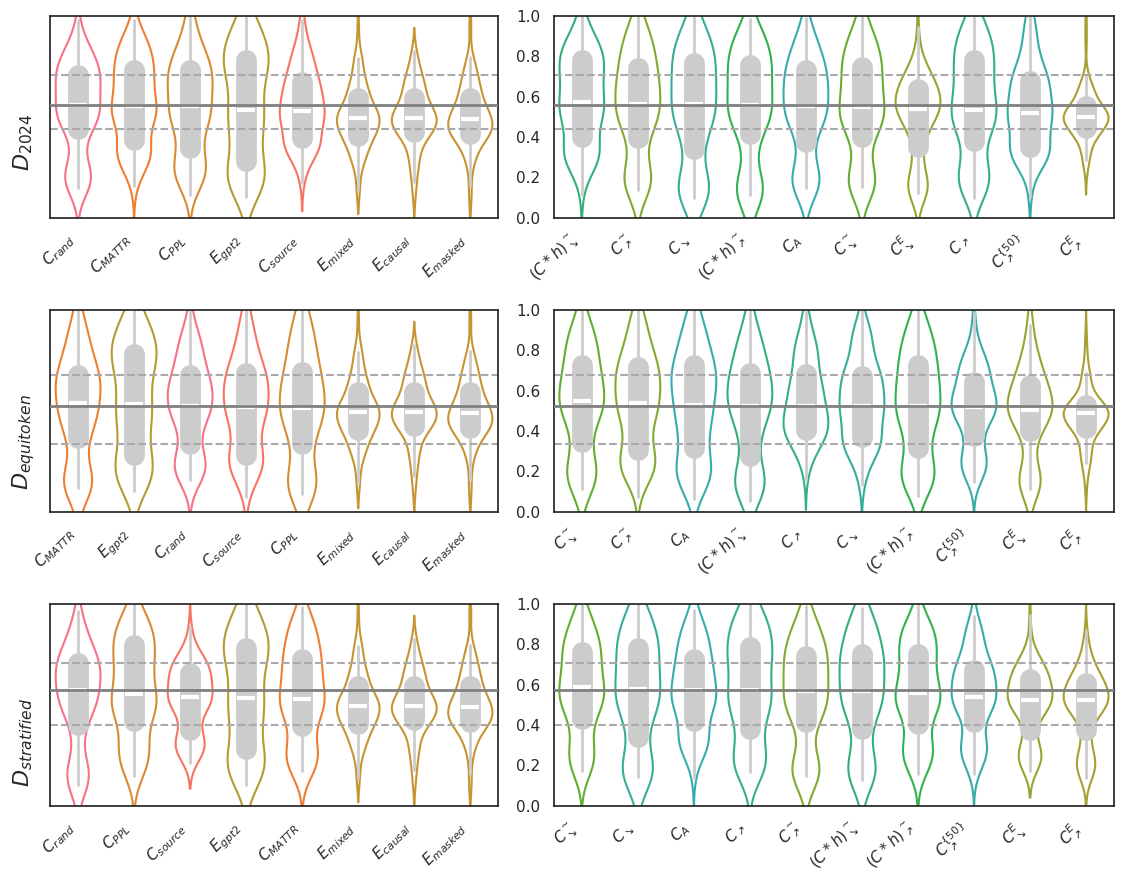

1.0


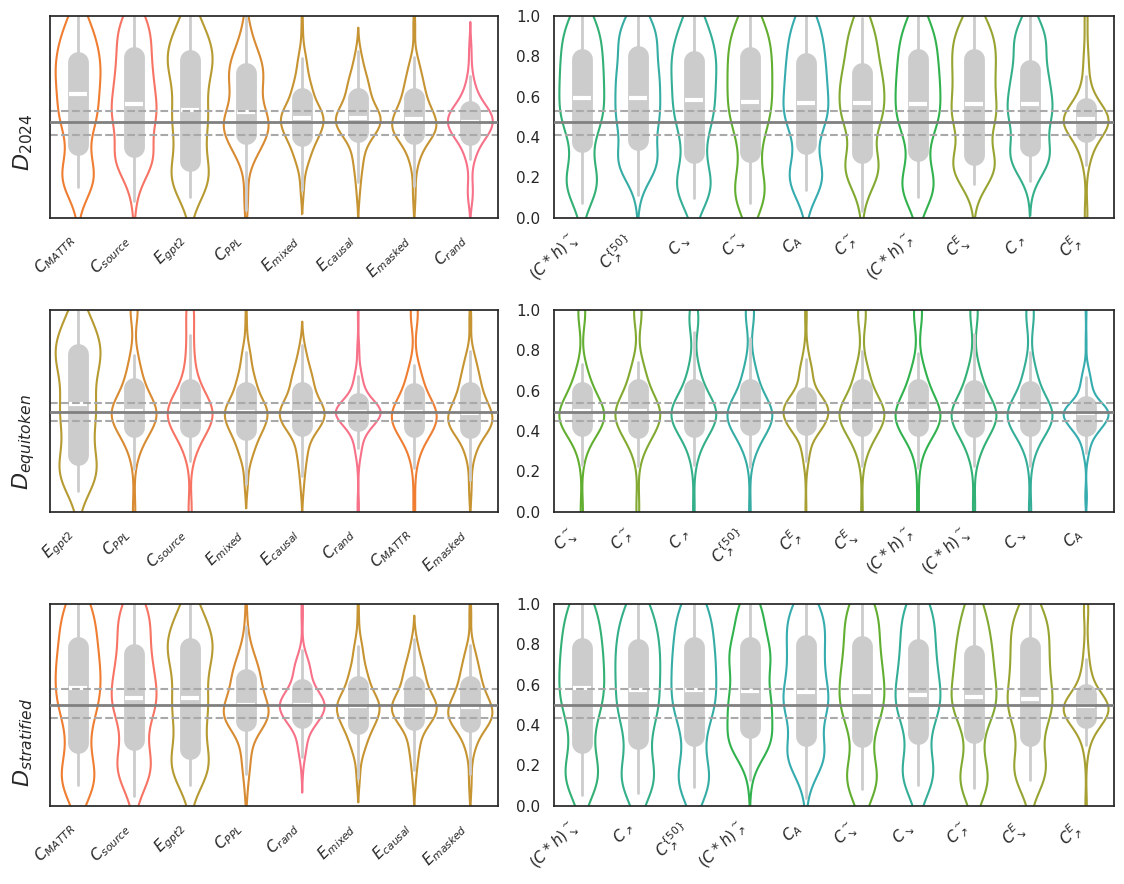

1.0


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import numpy as np
for model_type in config.model_types:
        
        df["plot_group"] = df["curriculum"].str.contains("influence")
        WIDTH_TWO_COL = 8.04

        sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

        n_rows = len(config.datasets) 
        n_cols = 2 
        fig = plt.figure(figsize=(WIDTH_TWO_COL*1.4, 3 * n_rows))

        gs = GridSpec(n_rows, 2, figure=fig, width_ratios=[8/18, 10/18]) 


        all_plotted_models = set()

        temp_df = df[df["model"].str.contains("|".join(config.datasets))] 
        for baseline_dataset in config.datasets:
                model_data_pre = temp_df[temp_df["model"].str.contains(baseline_dataset)]
                for plot_group in model_data_pre["plot_group"].unique():
                        group_data_pre = model_data_pre[model_data_pre["plot_group"] == plot_group]
                        
                        model_medians_index = group_data_pre.groupby("model")["acc"].median().sort_values(ascending=False).index
                        all_plotted_models.update(model_medians_index)

        unique_model_list = sorted(list(all_plotted_models))
        num_unique_models = len(df[df["dataset"] ==df["dataset"].unique()[0]]["model"].unique())
        global_palette = sns.color_palette("husl", n_colors=num_unique_models)




        n_baseline_curricula = len(df[df["plot_group"] == False]["curriculum"].unique())
        axes = [[None for _ in range(n_cols)] for _ in range(n_rows)] 


        for i, baseline_dataset in enumerate(config.datasets):
 
                model_data = df[(df["model"].str.contains(baseline_dataset) & (df["model_type"] == model_type)) | (df["model"].str.contains("gpt-bert") | df["model"].str.contains("gpt2"))]
            
                
                col_idx = 0
                plot_groups_in_data = model_data["plot_group"].unique()

                for is_baseline_half in plot_groups_in_data:

                        axes[i][col_idx] = fig.add_subplot(gs[i, col_idx])
                        ax = axes[i][col_idx]

                        
                        group_data = model_data[model_data["plot_group"] == is_baseline_half]

                        
                        model_medians = group_data.groupby("model")["acc"].median().sort_values(ascending=False).index


                        sns.violinplot(data=group_data,
                                        x="model", y="acc",
                                        ax=ax,
                                        hue="curriculum",
                                        fill=False,             
                                        palette=global_palette[n_baseline_curricula:] if is_baseline_half else global_palette, 
                                        order=model_medians,
                                        inner_kws=dict(box_width=15, whis_width=2, color=".8"),
                                        legend=False           
                                        )

                        # Custom X-tick label formatting
                        current_xticklabels = ax.get_xticklabels()
                        new_xticklabels = [util.rename_model(label.get_text()) for label in current_xticklabels]
                        ax.set_xticklabels(new_xticklabels, rotation=45, ha="right")

                
                        random_model_name = f"{baseline_dataset}_{model_type}_random"
                        if random_model_name in df["model"].unique():
                                random_acc = df[df["model"] == random_model_name]["acc"]
                                if not random_acc.empty:
                                        ax.axhline(random_acc.median(), ls='-', zorder=10, linewidth=2, color="gray")
                                        ax.axhline(random_acc.quantile(0.25), ls='--', color="darkgrey") 
                                        ax.axhline(random_acc.quantile(0.75), ls='--', color="darkgrey") 

                        
                        if ax.get_legend() is not None:
                                ax.get_legend().remove()

                        ax.set_title("") 
                        ax.set_xlabel("")
                        ax.set_ylim(0,1)

                        if not is_baseline_half:
                                ax.set_ylabel("")
                                ax.set_yticks([])

                        else:
                                ax.set_ylabel("")
                                ax.set_ylabel("")



                        col_idx += 1 

        
                fig.text(0.015, (n_rows - 1 - i + 0.5) / n_rows,
                        util.rename_dataset(baseline_dataset),
                        ha="center",
                        va="center",
                        fontsize=16,
                        rotation=90,
                        fontweight="heavy")
                

        plt.tight_layout() 

        util.save_pdf(fig, "violin_plots_"+model_type)
        plt.show()
        print(df["acc"].max())

In [10]:
def get_random_baseline(x):
    x = os.path.basename(x)
    dataset = None
    for d in config.datasets:
        if os.path.basename(d) in x:
            dataset = d
    model_type = None
    for m in config.model_types:

        if os.path.basename(m) in x:
            model_type = m
    if dataset is None or model_type is None:
        return "external"    
    else:
        return df[df["model"].str.contains(os.path.basename(dataset)+"_"+os.path.basename(model_type)+"_random")]["model"].iloc[0]
 
def get_source_difficulty_baseline(x):
    x = os.path.basename(x)
    dataset = None
    for d in config.datasets:
        if os.path.basename(d) in x:
            dataset = d
    model_type = None
    for m in config.model_types:

        if os.path.basename(m) in x:
            model_type = m
    if dataset is None or model_type is None:
        return "external"    
    else:
        return df[df["model"].str.contains(os.path.basename(dataset)+"_"+os.path.basename(model_type)+"_source_difficulty")]["model"].iloc[0]
 

In [11]:
def get_model_type(x):
    if "roberta" in x: 
        return "RoBERTa"
    if "llama" in x :
        return "Llama"
    if "gpt-bert" in x:
        return "gpt-bert"
    print("f", x)

In [12]:
import pandas as pd
from scipy import stats
import numpy as np
models = df["model"].unique()


results = []

for model in models:
    random_acc = pd.to_numeric(df[df["model"] == get_random_baseline(model)]["acc"])
    source_model_acc = pd.to_numeric(df[df["model"] == get_source_difficulty_baseline(model)]["acc"])
    model_acc = pd.to_numeric(df[df["model"] == model]["acc"])

    t_stat, p_val = np.nan, np.nan
    if "external" not in get_random_baseline(model):
        t_stat, p_val = stats.ttest_rel(model_acc, random_acc,alternative="two-sided")

       
    avg_improvement = (model_acc - random_acc).mean() *100
    average_improvement_source_difficulty = (model_acc-source_model_acc).mean() *100
    results.append((model, model_acc.mean(), random_acc.mean() if not "rand" in model else "-", p_val, avg_improvement if not "external" in model else "-", p_val < 0.05,average_improvement_source_difficulty if not "external" in model else "-"))

results_df = pd.DataFrame(results, columns=["model","model_acc", "random_acc","p_value","average_improvement", "significant","average_improvement_source_difficulty"])

table = results_df.sort_values(by="average_improvement")
def format_with_significance(row):
    
    val = f"{row['average_improvement']:+.2f} pp"
    if row['p_value'] < 0.01:
        val += "***"
    elif row['p_value'] < 0.05:
        val += "**"
    elif row['p_value'] < 0.1:
        val += "*"

    return val if "nan" not in val else "-"


table["formatted_improvement"] = table.apply(format_with_significance, axis=1)

table["dataset"] = table["model"].apply(lambda x: util.rename_dataset(util.get_dataset(x)))
table["curriculum"] = table["model"].apply(lambda x: util.rename(util.get_curriculum_name(x)))
table["model_type"] = table["model"].apply(get_model_type)
table["model"] = table["model"].apply(util.rename_model)




baseline = table[table["curriculum"].isin(["external", "$C_{rand}$"])].sort_values(by="model_acc")
others = table[~table["curriculum"].isin(["external", "$C_{rand}$"])]


ordered_table = pd.concat([baseline, others])



result = ordered_table[["model", "dataset", "model_type", "formatted_improvement", "p_value", "model_acc", "random_acc"]]

result = result.rename(columns={
    "formatted_improvement" : "Improvement",
    "model" : "Curriculum",
    "dataset" : "Dataset",
    "model_type": "Architecture",
    "p_value" : "p-val",
    "model_acc" : "Model acc",
    "random_acc" : "Random acc"
    })

result = result.fillna("-")
latex_code = result.to_latex(index=False, escape=False,float_format="%.3f",multirow=False,longtable=True,caption="Macro-average gain in accuracy over the corresponding random curriculum.")
latex_lines = latex_code.split("\n")


last_baseline_idx = len(baseline) 


line_to_insert_after = last_baseline_idx + 17 


latex_lines.insert(line_to_insert_after, "\\hline \\hline")

latex_code_with_double_line = "\n".join(latex_lines)

with open("./autogenerated_figures/tabular_full_benchmark_results.tex", "w") as f:
    f.write(latex_code_with_double_line)

f BabyLM-community/babylm-baseline-10m-gpt2


In [13]:
table.to_pickle("./plotting_notebooks/cache/benchmark_results.pkl")

In [14]:
out = pd.DataFrame(table.groupby("curriculum")["average_improvement"].mean().sort_values()).rename(columns={
    "average_improvement" : "Improvement",
    "model" : "Curriculum",
    "dataset" : "Dataset",
    "model_type": "Architecture",
    "p_value" : "p-val",
    "model_acc" : "Model acc",
    "random_acc" : "Random acc"
    }).to_latex(index=True, escape=False,float_format="%.3f",multirow=False)
with open("./autogenerated_figures/tabular_aggregated_results_curricula_level.tex", "w") as f:
    f.write(out)

In [15]:
out = pd.DataFrame(table.groupby(["model_type","curriculum"])["average_improvement"].mean().sort_values()).reset_index().rename(columns={
    "average_improvement" : "Improvement",
    "model" : "Curriculum",
    "dataset" : "Dataset",
    "model_type": "Architecture",
    "p_value" : "p-val",
    "model_acc" : "Model acc",
    "model_type" : "Type",
    "random_acc" : "Random acc"
    }).to_latex(index=False, escape=False,float_format="%.3f",multirow=False)
with open("./autogenerated_figures/tabular_per_model_type.tex", "w") as f:
    f.write(out)

In [16]:
table

,model,model_acc,random_acc,p_value,average_improvement,significant,average_improvement_source_difficulty,formatted_improvement,dataset,curriculum,model_type
44,$C^E_{\nearrow}$,0.472962,0.523169,0.032952,-5.020654,True,-4.904843,-5.02 pp**,$D_{equitoken}$,$C^E_{\nearrow}$,Llama
25,$C^E_{\searrow}$,0.492668,0.541044,0.003781,-4.837526,True,-5.902581,-4.84 pp***,$D_{2024}$,$C^E_{\searrow}$,Llama
64,$C^E_{\nearrow}$,0.487612,0.535545,0.004585,-4.793332,True,-3.406994,-4.79 pp***,$D_{stratified}$,$C^E_{\nearrow}$,Llama
24,$C^E_{\nearrow}$,0.502732,0.541044,0.064918,-3.831192,False,-4.896247,-3.83 pp*,$D_{2024}$,$C^E_{\nearrow}$,Llama
65,$C^E_{\searrow}$,0.504436,0.535545,0.002350,-3.110941,True,-1.724603,-3.11 pp***,$D_{stratified}$,$C^E_{\searrow}$,Llama
...,...,...,...,...,...,...,...,...,...,...,...
42,$C^{\{50\}}_{\nearrow}$,0.589897,0.465683,0.000011,12.421372,True,0.650549,+12.42 pp***,$D_{2024}$,$C^{\{50\}}_{\nearrow}$,RoBERTa
84,$E_{mixed}$,0.497867,NaN,NaN,NaN,False,NaN,-,ext,$E_{mixed}$,gpt-bert
85,$E_{causal}$,0.502034,NaN,NaN,NaN,False,NaN,-,ext,$E_{causal}$,gpt-bert
86,$E_{masked}$,0.503660,NaN,NaN,NaN,False,NaN,-,ext,$E_{masked}$,gpt-bert


In [17]:
out = pd.DataFrame(
    table[table["curriculum"] == "$C_{rand}$"]
    .set_index(["dataset","model_type"])["model_acc"]
    .sort_values()
    .unstack(level="model_type")  # This brings model types side by side
    .reset_index()
    .rename(columns={
        "curriculum": "Curriculum",
        "dataset": "Dataset",
        "RoBERTa": "$C_{rand}$ acc RoBERTa",
        "Llama": "$C_{rand}$ acc Llama"
    })
).sort_values(by="$C_{rand}$ acc RoBERTa").to_latex(index=False, escape=False,float_format="%.3f",multirow=False,longtable=False)
with open("./autogenerated_figures/tabular_random_curricula.tex", "w") as f:
    f.write(out)

In [18]:
out = pd.DataFrame(table.sort_values(by="average_improvement_source_difficulty").set_index(["dataset","model_type","curriculum"])["average_improvement_source_difficulty"].sort_values()
.reset_index()
    .rename(columns={
        "curriculum": "Curriculum",
        "dataset": "Dataset",
        "model_type": "Type",
        "average_improvement_source_difficulty": "Average Improvement vs. $C_{source}$"
    })
).to_latex(index=False, escape=False,float_format="%.3f",multirow=False,longtable=True)
with open("./autogenerated_figures/tabular_vs_source.tex", "w") as f:
    f.write(out)

In [19]:
pd.DataFrame(
    table[table["curriculum"] == "$C_{rand}$"]
    .set_index(["dataset","model_type"])["model_acc"]
    .sort_values()
    .unstack(level="model_type")  # This brings model types side by side
    .reset_index())


model_type,dataset,Llama,RoBERTa
0,$D_{2024}$,0.541044,0.465683
1,$D_{equitoken}$,0.523169,0.492169
2,$D_{stratified}$,0.535545,0.512479


In [20]:
idx = table.groupby(["dataset"])['model_acc'].idxmax()
best_models = table.loc[idx][table["dataset"] != "ext"]

/tmp/ipykernel_1616461/3675217635.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_models = table.loc[idx][table["dataset"] != "ext"]


In [21]:
best_models

,model,model_acc,random_acc,p_value,average_improvement,significant,average_improvement_source_difficulty,formatted_improvement,dataset,curriculum,model_type
42,$C^{\{50\}}_{\nearrow}$,0.589897,0.465683,0.000011,12.421372,True,0.650549,+12.42 pp***,$D_{2024}$,$C^{\{50\}}_{\nearrow}$,RoBERTa
50,$C_\nearrow$,0.554766,0.523169,0.142147,3.159669,False,3.275480,+3.16 pp,$D_{equitoken}$,$C_\nearrow$,Llama
78,$(C*h)^{\sim}_{\nearrow}$,0.592062,0.512479,0.000207,7.958343,True,4.071178,+7.96 pp***,$D_{stratified}$,$(C*h)^{\sim}_{\nearrow}$,RoBERTa


In [22]:
pd.DataFrame(best_models.set_index(["dataset","curriculum","model_type"])["model_acc"].sort_values()).reset_index().rename(columns={
        "curriculum": "Best Curriculum",
        "dataset": "Dataset",
        "model_acc": "acc",
        "model_type":"Best Model"
    }).set_index("Dataset")


,Best Curriculum,Best Model,acc
Dataset,,,
$D_{equitoken}$,$C_\nearrow$,Llama,0.554766
$D_{2024}$,$C^{\{50\}}_{\nearrow}$,RoBERTa,0.589897
$D_{stratified}$,$(C*h)^{\sim}_{\nearrow}$,RoBERTa,0.592062


In [23]:
pd.merge(pd.DataFrame(
    table[table["curriculum"] == "$C_{rand}$"]
    .set_index(["dataset","model_type"])["model_acc"]
    .sort_values()
    .unstack(level="model_type")  # This brings model types side by side
    .reset_index()
    .rename(columns={
        "curriculum": "Curriculum",
        "dataset": "Dataset",
        "RoBERTa": "$C_{rand}$ acc RoBERTa",
        "Llama": "$C_{rand}$ acc Llama"
    })).set_index("Dataset"),
   pd.DataFrame(best_models.set_index(["dataset","curriculum","model_type"])["model_acc"].sort_values()).reset_index().rename(columns={
        "curriculum": "Best Curriculum",
        "dataset": "Dataset",
        "model_acc": "acc",
        "model_type":"Best Model"
    }).set_index("Dataset")
, on="Dataset"
).sort_values(by="acc")

,$C_{rand}$ acc Llama,$C_{rand}$ acc RoBERTa,Best Curriculum,Best Model,acc
Dataset,,,,,
$D_{equitoken}$,0.523169,0.492169,$C_\nearrow$,Llama,0.554766
$D_{2024}$,0.541044,0.465683,$C^{\{50\}}_{\nearrow}$,RoBERTa,0.589897
$D_{stratified}$,0.535545,0.512479,$(C*h)^{\sim}_{\nearrow}$,RoBERTa,0.592062


In [24]:
out = pd.merge(pd.DataFrame(
    table[table["curriculum"] == "$C_{rand}$"]
    .set_index(["dataset","model_type"])["model_acc"]
    .sort_values()
    .unstack(level="model_type")  # This brings model types side by side
    .reset_index()
    .rename(columns={
        "curriculum": "Curriculum",
        "dataset": "Dataset",
        "RoBERTa": "$C_{rand}$ acc RoBERTa",
        "Llama": "$C_{rand}$ acc Llama"
    })).set_index("Dataset"),
   pd.DataFrame(best_models.set_index(["dataset","curriculum","model_type"])["model_acc"].sort_values()).reset_index().rename(columns={
        "curriculum": "Best Curriculum",
        "dataset": "Dataset",
        "model_acc": "acc",
        "model_type":"Best Model"
    }).set_index("Dataset")
, on="Dataset"
).sort_values(by="acc").reset_index().to_latex(index=False, escape=False,float_format="%.3f",multirow=False,longtable=False)
with open("./autogenerated_figures/tabular_random_curricula.tex", "w") as f:
    f.write(out)

In [25]:
a = pd.DataFrame(
    table[table["curriculum"] == "$C_{rand}$"]
    .set_index(["dataset","model_type"])["model_acc"]
    .sort_values()
    .unstack(level="model_type")  # This brings model types side by side
    .reset_index()
    .rename(columns={
        "curriculum": "Curriculum",
        "dataset": "Dataset",
        "RoBERTa": "$C_{rand}$ acc RoBERTa",
        "Llama": "$C_{rand}$ acc Llama"
    }))
(a["$C_{rand}$ acc Llama"] - a["$C_{rand}$ acc RoBERTa"]).describe()

count    3.000000
mean     0.043142
std      0.028182
min      0.023066
25%      0.027033
50%      0.031000
75%      0.053180
max      0.075360
dtype: float64

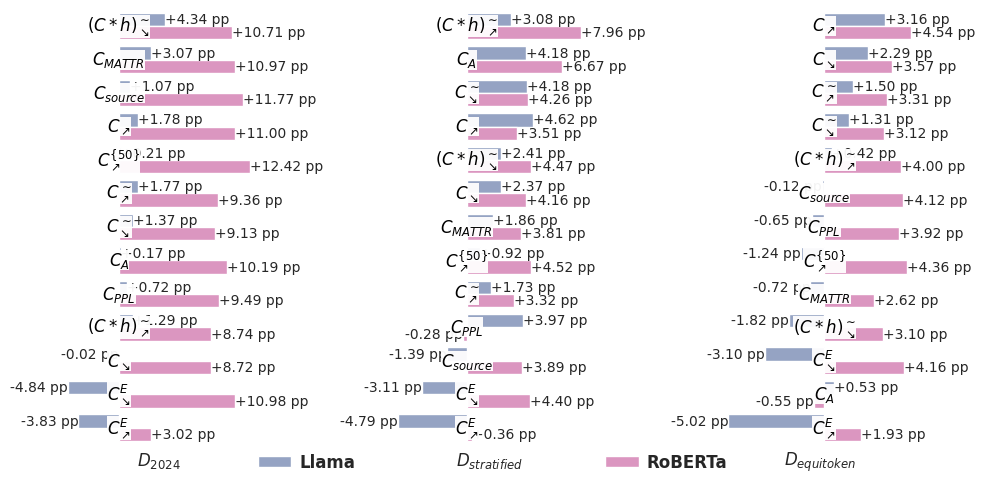

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


datasets = ['$D_{2024}$', '$D_{stratified}$', '$D_{equitoken}$', 'ext']#table["dataset"].unique()
# print(datasets)
# 
palette = sns.color_palette("Set2")[2:]
sns.set_palette(palette)
fig, axes = plt.subplots(1, 3, figsize=(10, 5),)

for ax,dataset in zip(axes,datasets):


    df = pd.DataFrame(
        table[
            (table["curriculum"] != "$C_{rand}$") &
            (table["dataset"] == dataset)
        ].groupby(["model_type", "curriculum"])["average_improvement"].mean()
    ).reset_index().rename(columns={
        "average_improvement": "Improvement",
        "curriculum": "Curriculum",
        "dataset": "Dataset",
        "model_type": "Architecture",
        "p_value": "p-val",
        "model_acc": "Model acc",
        "model_type": "Type",
        "random_acc": "Random acc"
    })
    # display(df.groupby("Curriculum")["Improvement"].mean().sort_values().index)

    sns.barplot(
        data=df,
        x="Improvement",
        y="Curriculum",
        hue="Type",
        ax=ax,
        order=df.groupby("Curriculum")["Improvement"].mean().sort_values(ascending=False).index
    )

    # Add curriculum labels
    curricula = [label.get_text() for label in ax.get_yticklabels()]
    for i, curriculum in enumerate(curricula):
        ax.text(0, i, curriculum, ha='center', va='center', fontsize=12, fontweight='bold', color='black', zorder=4,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle=f"square,pad={0}", alpha=0.95,),
        )

    # Add value labels to bars
    for container in ax.containers:
        ax.bar_label(container, fontsize=10, fmt='%+.2f pp')

    ax.set_yticks([])
    ax.set_xticks([])

    ax.set_xlabel(dataset)
    ax.set_ylabel("")

    if ax.get_legend():
        ax.get_legend().remove()

    sns.despine(left=True, right=True, top=True, bottom=True)
    plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()
import matplotlib.font_manager as font_manager

font_bold = font_manager.FontProperties(weight='bold', size=12) 

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), frameon=False,
           facecolor='white', fontsize=12, markerscale=0.5, labelspacing=0.3,
           handletextpad=0.5, ncol=2, columnspacing=15,
           prop=font_bold)
util.save_pdf(fig, "accuracy_delta_per_curriculum_and_dataset")
plt.show()


In [ ]:
table["group"] = table["model"].apply(lambda x: (1 if "searrow" in x else -1) if ("arrow" in x) and ("E" not in x) and ("A" not in x) and ("50" not in x) and ("*" not in x) else 0)

In [ ]:
table["group"] = table["model"].apply(lambda x: (1 if "searrow" in x else -1) if ("arrow" in x) and ("E" not in x) and ("A" not in x) and ("50" not in x) and ("*" not in x) else 0)


In [29]:
from scipy.stats import ttest_ind

for (model_type,dataset, curriculum), df in table.groupby([ "model_type","dataset","curriculum"]):
    print(model_type, dataset)


Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{2024}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{equitoken}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
Llama $D_{stratified}$
RoBERTa $D_{2024}$
RoBERTa $D_{2024}$
RoBERTa $D_{2024}$
RoBERTa $D_{2024}$
RoBERTa $D_{2024}$
RoBERTa $D_{2024}$
RoBERTa $D_{2024}$

In [30]:
from scipy.stats import ttest_ind

for (model_type), df in table.groupby([ "model_type","dataset"]):
    g1 = df[df["group"] != 1]["model_acc"]
    g_1 = df[df["group"] == -1]["model_acc"]
    t, p = ttest_ind(g1, g_1, equal_var=False,alternative="less")
    
    print(f"{dataset} | {model_type} | t={t:.2f} p={p:.4g}")


ext | ('Llama', '$D_{2024}$') | t=-1.74 p=0.05467
ext | ('Llama', '$D_{equitoken}$') | t=-2.83 p=0.04502
ext | ('Llama', '$D_{stratified}$') | t=-1.22 p=0.1782
ext | ('RoBERTa', '$D_{2024}$') | t=-0.83 p=0.2192
ext | ('RoBERTa', '$D_{equitoken}$') | t=-1.23 p=0.16
ext | ('RoBERTa', '$D_{stratified}$') | t=0.19 p=0.5735
ext | ('gpt-bert', 'ext') | t=nan p=nan


/usr/local/lib/python3.10/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [31]:
from scipy.stats import ttest_ind

for (model_type), df in table.groupby([ "model_type","dataset"]):
    g1 = df[df["group"] != 0]["model_acc"]
    g_1 = df[df["group"] == 0]["model_acc"]
    t, p = ttest_ind(g1, g_1, equal_var=False,alternative="greater")
    
    print(f"{dataset} | {model_type} | t={t:.2f} p={p:.4g}")


ext | ('Llama', '$D_{2024}$') | t=1.03 p=0.1615
ext | ('Llama', '$D_{equitoken}$') | t=4.66 p=0.0003327
ext | ('Llama', '$D_{stratified}$') | t=2.13 p=0.02805
ext | ('RoBERTa', '$D_{2024}$') | t=0.52 p=0.3054
ext | ('RoBERTa', '$D_{equitoken}$') | t=1.34 p=0.1022
ext | ('RoBERTa', '$D_{stratified}$') | t=0.26 p=0.4011
ext | ('gpt-bert', 'ext') | t=nan p=nan


/usr/local/lib/python3.10/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [ ]:
table["y"] = table["model_acc"] / pd.to_numeric(table["random_acc"], errors='coerce')

/tmp/ipykernel_1616461/1780831963.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  table[table["model_type"] == "Llama"][
/tmp/ipykernel_1616461/1780831963.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  table[table["model_type"] == "Llama"][
/tmp/ipykernel_1616461/1780831963.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  table[table["model_type"] == "Llama"][


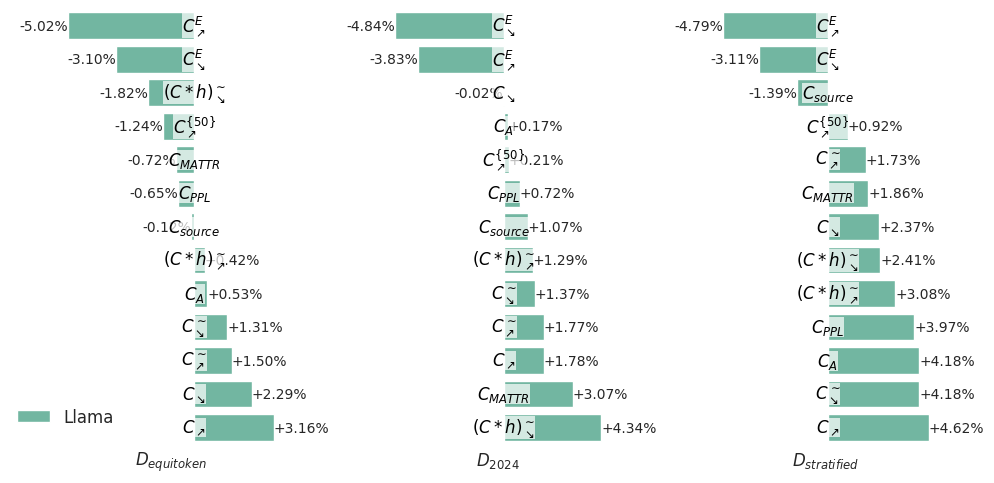

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


datasets = table["dataset"].unique()

# 
sns.set_palette("Set2")
fig, axes = plt.subplots(1, 3, figsize=(10, 5),)

for ax,dataset in zip(axes,datasets):


    df = pd.DataFrame(
        table[table["model_type"] == "Llama"][
            (table["curriculum"] != "$C_{rand}$") &
            (table["dataset"] == dataset)
        ].groupby(["model_type", "curriculum"])["average_improvement"].mean().sort_values()
    ).reset_index().rename(columns={
        "average_improvement": "Improvement",
        "curriculum": "Curriculum",
        "dataset": "Dataset",
        "model_type": "Architecture",
        "p_value": "p-val",
        "model_acc": "Model acc",
        "model_type": "Type",
        "random_acc": "Random acc"
    })

    sns.barplot(
        data=df,
        x="Improvement",
        y="Curriculum",
        hue="Type",
        ax=ax
    )

    # Add curriculum labels
    curricula = [label.get_text() for label in ax.get_yticklabels()]
    for i, curriculum in enumerate(curricula):
        ax.text(0, i, curriculum, ha='center', va='center', fontsize=12, fontweight='bold', color='black', zorder=4,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle=f"square,pad={0}", alpha=0.7,),
        )

    # Add value labels to bars
    for container in ax.containers:
        ax.bar_label(container, fontsize=10, fmt='%+.2f%%')

    ax.set_yticks([])
    ax.set_xticks([])

    ax.set_xlabel(dataset)
    ax.set_ylabel("")

    if ax.get_legend():
        ax.get_legend().remove()

    sns.despine(left=True, right=True, top=True, bottom=True)
    plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0,0.10), frameon=False,
           facecolor='white', fontsize=12, markerscale=0.5, labelspacing=0.3)




/tmp/ipykernel_1616461/19688063.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  table[table["model_type"] == "RoBERTa"][
/tmp/ipykernel_1616461/19688063.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  table[table["model_type"] == "RoBERTa"][
/tmp/ipykernel_1616461/19688063.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  table[table["model_type"] == "RoBERTa"][


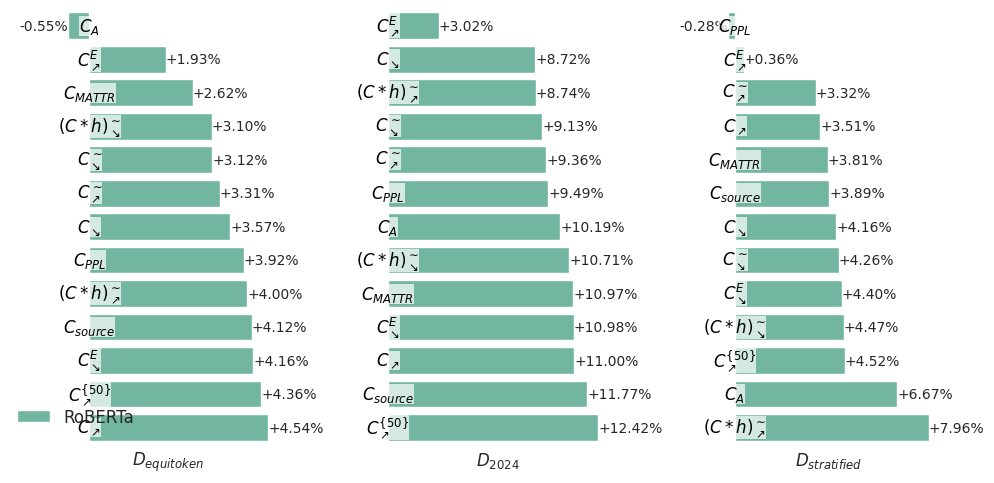

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


datasets = table["dataset"].unique()

# 
sns.set_palette("Set2")
fig, axes = plt.subplots(1, 3, figsize=(10, 5),)

for ax,dataset in zip(axes,datasets):


    df = pd.DataFrame(
        
        table[table["model_type"] == "RoBERTa"][
            (table["curriculum"] != "$C_{rand}$") &
            (table["dataset"] == dataset)
        ].groupby(["model_type", "curriculum"])["average_improvement"].mean().sort_values()
    ).reset_index().rename(columns={
        "average_improvement": "Improvement",
        "curriculum": "Curriculum",
        "dataset": "Dataset",
        "model_type": "Architecture",
        "p_value": "p-val",
        "model_acc": "Model acc",
        "model_type": "Type",
        "random_acc": "Random acc"
    })

    sns.barplot(
        data=df,
        x="Improvement",
        y="Curriculum",
        hue="Type",
        ax=ax
    )

    # Add curriculum labels
    curricula = [label.get_text() for label in ax.get_yticklabels()]
    for i, curriculum in enumerate(curricula):
        ax.text(0, i, curriculum, ha='center', va='center', fontsize=12, fontweight='bold', color='black', zorder=4,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle=f"square,pad={0}", alpha=0.7,),
        )

    # Add value labels to bars
    for container in ax.containers:
        ax.bar_label(container, fontsize=10, fmt='%+.2f%%')

    ax.set_yticks([])
    ax.set_xticks([])

    ax.set_xlabel(dataset)
    ax.set_ylabel("")

    if ax.get_legend():
        ax.get_legend().remove()

    sns.despine(left=True, right=True, top=True, bottom=True)
    plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0,0.10), frameon=False,
           facecolor='white', fontsize=12, markerscale=0.5, labelspacing=0.3)




In [35]:
table.sort_values(by="model_acc")

,model,model_acc,random_acc,p_value,average_improvement,significant,average_improvement_source_difficulty,formatted_improvement,dataset,curriculum,model_type,group,y
4,$C_{rand}$,0.465683,-,NaN,0.000000,False,-11.770823,+0.00 pp,$D_{2024}$,$C_{rand}$,RoBERTa,0,NaN
44,$C^E_{\nearrow}$,0.472962,0.523169,3.295207e-02,-5.020654,True,-4.904843,-5.02 pp**,$D_{equitoken}$,$C^E_{\nearrow}$,Llama,0,0.904034
63,$C_{A}$,0.486692,0.492169,7.262192e-01,-0.547667,False,-4.667091,-0.55 pp,$D_{equitoken}$,$C_{A}$,RoBERTa,0,0.988872
64,$C^E_{\nearrow}$,0.487612,0.535545,4.584825e-03,-4.793332,True,-3.406994,-4.79 pp***,$D_{stratified}$,$C^E_{\nearrow}$,Llama,0,0.910496
12,$C_{rand}$,0.492169,-,NaN,0.000000,False,-4.119424,+0.00 pp,$D_{equitoken}$,$C_{rand}$,RoBERTa,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,$C_\nearrow$,0.581717,0.535545,1.130107e-07,4.617192,True,6.003530,+4.62 pp***,$D_{stratified}$,$C_\nearrow$,Llama,-1,1.086215
5,$C_{source}$,0.583392,0.465683,1.151459e-05,11.770823,True,0.000000,+11.77 pp***,$D_{2024}$,$C_{source}$,RoBERTa,0,1.252764
29,$(C*h)^{\sim}_{\searrow}$,0.584426,0.541044,2.770782e-02,4.338199,True,3.273143,+4.34 pp**,$D_{2024}$,$(C*h)^{\sim}_{\searrow}$,Llama,0,1.080182
42,$C^{\{50\}}_{\nearrow}$,0.589897,0.465683,1.147040e-05,12.421372,True,0.650549,+12.42 pp***,$D_{2024}$,$C^{\{50\}}_{\nearrow}$,RoBERTa,0,1.266734


In [36]:
# import config
# data = { # language aquisition: (human-likeness, model-likeness)

# "source_difficulty.pt": (5,1),
# "mattr_increasing.pt": (4,1),
# "perplexity_increasing.pt": (3,2),
# "_influence_epoch_repetition.pt": (4,2),
# "_influence_decr_cp_dirac.pt": (2,3),
# "_influence_decr_bins_lognorm.pt": (3,3),
# "_influence_decr_bins_dirac.pt": (3,3),
# "_influence_incr_bins_lognorm.pt": (3,3),
# "_influence_incr_bins_dirac.pt": (3,3),

# "_influence_top_50_cp_shuffled.pt": (3,2),
# "_influence_tracin_sandwich.pt": (4,1),

# "_influence_incr_cp_dirac.pt": (2,3),
# "random.pt": (1,5),


# }
# for c in config.baseline_curricula:
#     if c not in data:
#         print(c)

In [ ]:
# table.groupby(["curriculum", "model_type"])["average_improvement"].mean().sort_values()

In [ ]:
# table.groupby("dataset")["average_improvement"].mean().sort_values()

In [ ]:
# table.groupby(["dataset"])["average_improvement"].mean().sort_values()